In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [63]:
%pwd
%cd /content/gdrive/MyDrive/Colab Notebooks/hackathon/

/content/gdrive/MyDrive/Colab Notebooks/hackathon


In [64]:
%pwd
import pandas as pd
import numpy as np
from typing import *
import typing
from datetime import datetime
import geopy
from geopy.distance import great_circle as GC 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns



df = pd.read_csv("nuclear_df.csv")
df['kw_thermal'].fillna((df['kw_thermal'].median()), inplace=True)
df_particulate = pd.read_csv("Chernobyl_Chemical_Radiation.csv")

#0.007 per megawatt

# The total energy released in a reactor is about 210 MeV (Mega Electron Volt) per 235U fission,
# the average recoverable energy per fission is about 200 MeV, (total energy -  antineutrinos)
# about 3.1 x 10^10 fissions (per second) are required to produce a thermal power of 1 W.
# 1 gram of any fissile material contains about 2.5 x 10^21 nuclei,
# fissioning of 1 gram of fissile material yields about 1 megawatt-day (MWd)

#energy recovered 
Er = 200.7 #MeV/fission
calculate_U235_consumption_per_day(Er, dataFrame=df)
#uranium 235 mass 
U235_mass_per_atom = 3.9 * 10**-25
fuel_cycle = 320 #days
df['uranium_per_year_kg'] = df['uranium_per_day_lbs']*fuel_cycle
#df['uranium_per_day_lbs'] = df['capacity_mw']*0.168
df.drop(columns=["capacity_mw", 'gppd_idnr', 'owner', 'source', 'url', 
                 'year_of_capacity_data', 'uranium_per_day_lbs', 'geolocation_source',
                 'commissioning_year'], axis=1, inplace=True)

chernobyl_latitude = 51.27222
chernobyl_longitude = 30.22417
iodine_131_half_life = 8.02 #days (very volatile appears in organism within 3 days)
Caesium_134_half_life = 799 #days	

make_distance_feature(df_particulate)

time_elapsed_explosion(df_particulate, explosition_date='1986-04-26')
print(df_particulate['Date'][0].replace("/","-"))
df_particulate.drop(columns=["Longitude", 'Latitude', 'Date', 'Location', 'Code', 'PAYS'], axis=1, inplace=True)#remove useless cols
df_particulate.head()


86-04-27


,I_131_(Bq/m3),Cs_134_(Bq/m3),Cs_137_(Bq/m3),distance_from_chernobyl,time_elapsed_hrs
0,1,0,0.24,1293.323992,24
1,0.0046,0.00054,0.00098,1293.323992,48
2,0.0147,0.0043,0.0074,1293.323992,72
3,0.00061,0,0.00009,1293.323992,72
4,0.00075,0.0001,0.00028,1293.323992,96


In [65]:
df.head()

,Unnamed: 0,country_long,kw_thermal,name,latitude,longitude,uranium_per_day_kg,uranium_per_year_kg
0,72,Argentina,1179.0,ATUCHA I,-33.9670,-59.2059,1.2372,1.174888e+22
1,73,Argentina,2000.0,ATUCHA II,-33.9674,-59.2045,2.0987,1.993024e+22
2,197,Argentina,2109.0,EMBALSE,-32.2316,-64.4422,2.2130,2.101644e+22
3,294,Armenia,1375.0,Armenian-2,40.1805,44.1498,1.4428,1.370204e+22
4,942,Belgium,2988.0,DOEL 4,51.3254,4.2597,3.1354,2.977578e+22


# Correlation between Ceasium 134, Ceasium 137 and Iodine 131



*   Ceasium 134 and Ceasium 137 have a correlation of about 80%
*   ceasium 137 and Iodine 131 about 70%
* 



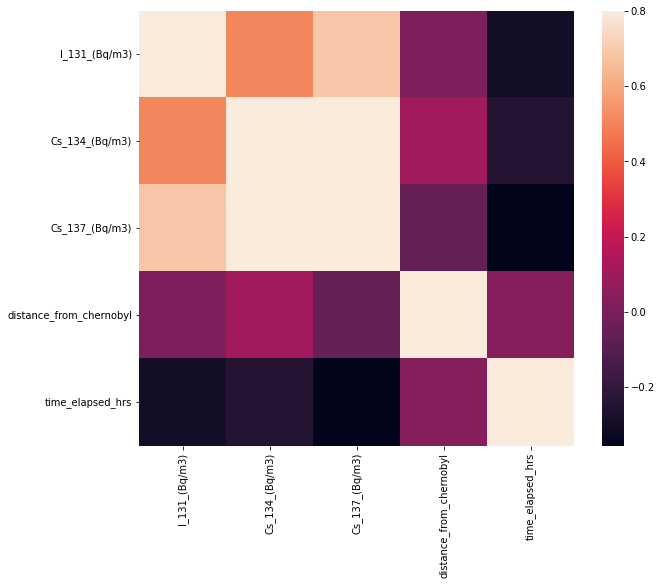

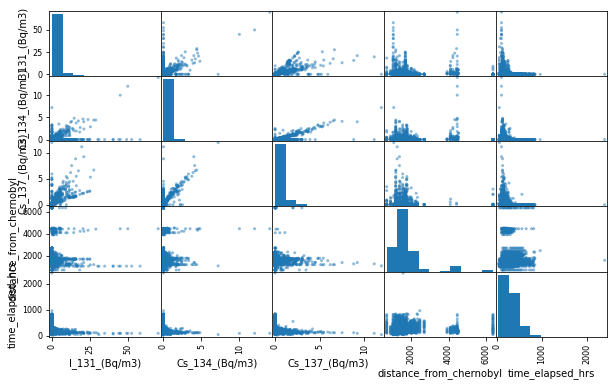

443.789347

In [83]:
#cm = np.corr(df_particulate)
from pandas.plotting import scatter_matrix
corrmat = df_particulate.corr()
f, ax = plt.subplots(figsize=(10, 8))


df_particulate[df_particulate.columns] = df_particulate[df_particulate.columns].apply(pd.to_numeric, errors='coerce')

#df_particulate = df_particulate.fillna(df_particulate.median())  # works

#df_particulate['I_131_(Bq/m3)'].fillna(df_particulate['I_131_(Bq/m3)'].median())
#df_particulate['Cs_134_(Bq/m3)'].fillna(df_particulate['Cs_134_(Bq/m3)'].median())
df_particulate['I_131_(Bq/m3)'].fillna(df_particulate['I_131_(Bq/m3)'].median(), inplace=True)
df_particulate['Cs_134_(Bq/m3)'].fillna(df_particulate['Cs_134_(Bq/m3)'].median(), inplace=True)

df_particulate[df_particulate['I_131_(Bq/m3)'].isna()];
df_particulate[df_particulate['Cs_134_(Bq/m3)'].isna()];

#sns.set(font_scale=1.25)
sns.heatmap(corrmat, vmax=.8, square=True);
#df_particulate.head()
#plt.show()

attributes = ['I_131_(Bq/m3)', 'Cs_134_(Bq/m3)', 'Cs_137_(Bq/m3)', 'distance_from_chernobyl', 'time_elapsed_hrs']
scatter_matrix(df_particulate[attributes], figsize=(10,6))
plt.show()
df_particulate['Cs_134_(Bq/m3)'].sum()
##ceasium 137 and 134 seem strongly correlated (80%)
##

## CEASIUM 137 6% OF SPENT FIEUL
## 

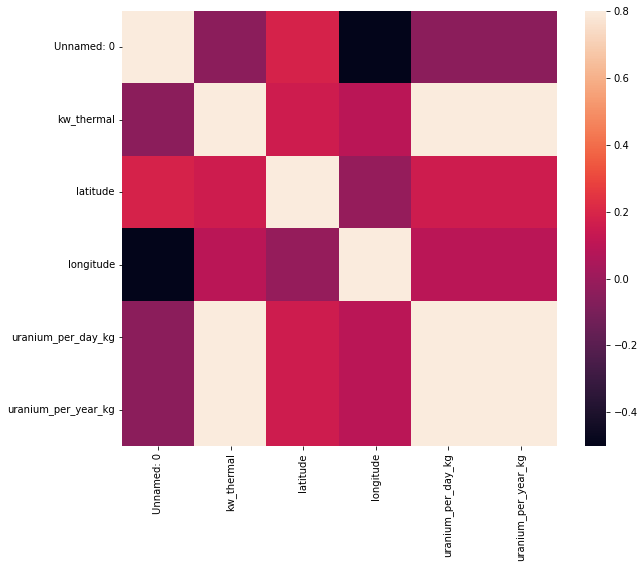

In [68]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

      distance_from_chernobyl  time_elapsed_hrs
0                 1293.323992                24
1                 1293.323992                48
2                 1293.323992                72
3                 1293.323992                72
4                 1293.323992                96
...                       ...               ...
2046               906.604187               264
2047               906.604187               288
2048               906.604187               312
2049               906.604187               336
2050               906.604187               360

[2051 rows x 2 columns]
(513,)
(513,)
(1538,)


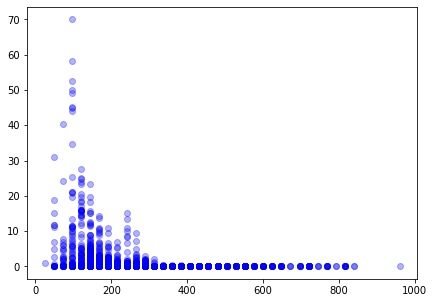

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

X = df_particulate[['distance_from_chernobyl', 'time_elapsed_hrs']]


y_I_131 = df_particulate['I_131_(Bq/m3)']
y_Cs_134 = df_particulate['Cs_134_(Bq/m3)']
y_Cs_137 = df_particulate['Cs_137_(Bq/m3)']
#X.head()
print(X)

linear_regression = LinearRegression()

fig, ax = plt.subplots(figsize=(7,5))
#y_pred = lr.predict(x_pred_range)

X_train_I_131, X_test_I_131, y_train_I_131, y_test_I_131 = train_test_split(X, y_I_131, test_size = 0.25, random_state=42)
linear_regression.fit(X_train_I_131, y_train_I_131)
y_pred_1 = linear_regression.predict(X_test_I_131)

#y_train_I_131, y_test_I_131 = pd.DataFrame(y_train_I_131.shape), pd.DataFrame(y_test_I_131)

print(y_test_I_131.shape)
print(y_test_I_131.shape)
print(y_train_I_131.shape)

#ax.scatter(X_test_I_131['time_elapsed_hrs'], y_test_I_131, alpha=0.3, c='r');
ax.scatter(X_train_I_131['time_elapsed_hrs'], y_train_I_131, alpha=0.3, c='b');
#ax.plot([X_train_I_131['time_elapsed_hrs'].min(), X_train_I_131['time_elapsed_hrs'].max()], [y_train_I_131.min(), y_train_I_131.max()], 'r--', lw=3)
#ax.plot(x_pred_range, y_pred_1, c='k');

In [14]:
def calculate_U235_consumption_per_day(Energy_recovered: int, dataFrame: pd.DataFrame):
  #uranium_used_per_day = thermal_outputs 
  Er = Energy_recovered
  U235_mass_per_atom = 3.9 * 10**-25
  dataFrame['uranium_per_day_lbs'] = (dataFrame['kw_thermal']* 10**6 / ((Er * 10**6 )* (1.6 * 10**-19)))
  dataFrame['uranium_per_day_kg'] = dataFrame['uranium_per_day_lbs']* U235_mass_per_atom * 86400
  dataFrame['uranium_per_day_kg'] = dataFrame['uranium_per_day_kg'].apply(lambda x: round(x, 4))
  #return dataFrame

def time_elapsed_explosion(dataFrame: pd.DataFrame, explosition_date: str):
  dates = []
  date_1 = explosition_date
  for index in range(0, dataFrame['Date'].shape[0]):

    if index == 0:
      date_2 = "19"+str(dataFrame['Date'][index]).replace("/", "-")
    else:
      date_2 = "19"+dataFrame['Date'][index].replace("/", "-")

    date_format_str = '%Y-%m-%d'
    start = datetime.strptime(date_1, date_format_str)
    end = datetime.strptime(date_2, date_format_str)
    diff = end - start
    diff_in_hours = round(diff.total_seconds() / 3600)#in hours
    dates.append(diff_in_hours)
    dataFrame['time_elapsed_hrs'] = pd.Series(dates)
  return diff_in_hours

def distance_to_ground_zero(lat_long_ground_zero: Tuple, current_lat_long: Tuple):
  dist = geopy.distance(lat_long_ground_zero, current_lat_long).km
  return dist

def make_distance_feature(dataFrame: pd.DataFrame):
  distances = []
  for index in range(0, dataFrame.shape[0]):
    dist = GC((chernobyl_latitude, chernobyl_longitude), (dataFrame['Latitude'][index], dataFrame['Longitude'][index])).km
    distances.append(dist)
  dataFrame['distance_from_chernobyl'] = pd.Series(distances) ##add feature